In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from collections import Counter

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [4]:
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [5]:
project_data.shape

(109248, 19)

## Clean Data

#### Subject categories

In [6]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [7]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

#### Subject sub categories

In [8]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [9]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

#### Preprocess Essay

In [10]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:08<00:00, 1599.21it/s]


In [12]:
project_data.drop(['essay'], axis=1, inplace=True)

In [13]:
project_data['essay'] = preprocessed_essays

#### Preprocess Title

In [14]:
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 38221.68it/s]


In [15]:
project_data.drop(['project_title'], axis=1, inplace=True)

In [16]:
project_data['project_title'] = preprocessed_title

##### Preprocess project_resource_summary

In [17]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_resource_summary'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_summary.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:06<00:00, 15919.88it/s]


In [18]:
project_data.drop(['project_resource_summary'], axis=1, inplace=True)

In [19]:
project_data['summary'] = preprocessed_summary

In [20]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,essay,project_title,summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,0,0,154.6,23,Literacy_Language,ESL Literacy,my students english learners working english s...,educational support english learners home,my students need opportunities practice beginn...


In [21]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_essay_1,project_essay_2,project_essay_3,project_essay_4,teacher_number_of_previously_posted_projects,price,quantity,clean_categories,clean_subcategories,essay,project_title,summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,0,154.6,23,Literacy_Language,ESL Literacy,my students english learners working english s...,educational support english learners home,my students need opportunities practice beginn...


In [22]:
y[0:10,]

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [23]:
X = project_data
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, stratify=y)

## Categorical features

## school_state

In [24]:
vectorizer = CountVectorizer()
vectorizer.fit(X_tr['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_tr['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_te['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_tr.shape)
print(X_test_state_ohe.shape, y_te.shape)
print(vectorizer.get_feature_names())

After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


## teacher_prefix

In [25]:
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document

vectorizer = CountVectorizer()
vectorizer.fit(X_tr['teacher_prefix'].values.astype('U')) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_tr['teacher_prefix'].values.astype('U'))
X_test_teacher_ohe = vectorizer.transform(X_te['teacher_prefix'].values.astype('U'))
print("After vectorizations")
print(X_train_teacher_ohe.shape, y_tr.shape)
print(X_test_teacher_ohe.shape, y_te.shape)
print(vectorizer.get_feature_names())

After vectorizations
(73196, 6) (73196,)
(36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'nan', 'teacher']


## clean_categories

In [26]:
vectorizer = CountVectorizer()
vectorizer.fit(X_tr['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_tr['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_te['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_ohe.shape, y_tr.shape)
print(X_test_clean_categories_ohe.shape, y_te.shape)
print(vectorizer.get_feature_names())

After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


## clean_subcategories

In [27]:
vectorizer = CountVectorizer()
vectorizer.fit(X_tr['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_tr['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_te['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, y_tr.shape)
print(X_test_clean_subcategories_ohe.shape, y_te.shape)
print(vectorizer.get_feature_names())

After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


## project_grade_category

In [28]:
vectorizer = CountVectorizer()
vectorizer.fit(X_tr['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_tr['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_te['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_tr.shape)
print(X_test_grade_ohe.shape, y_te.shape)
print(vectorizer.get_feature_names())

After vectorizations
(73196, 3) (73196,)
(36052, 3) (36052,)
['12', 'grades', 'prek']


## Numerical Features

##  Price

In [29]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_tr['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_tr['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_te['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_tr.shape)
print(X_test_price_norm.shape, y_te.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


##  teacher_number_of_previously_posted_projects

In [30]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_tnppp_norm = normalizer.transform(X_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnppp_norm = normalizer.transform(X_te['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_tnppp_norm.shape, y_tr.shape)
print(X_test_tnppp_norm.shape, y_te.shape)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


#  Hyper parameter Tuning

In [31]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [32]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(fpr*(1-tpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Bag of Words

In [62]:
print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)


from sklearn.feature_extraction.text import CountVectorizer
bowvectorizer = CountVectorizer(min_df=10,ngram_range=(1,4)) 
bowvectorizer.fit(X_tr['essay'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary_bow1 = bowvectorizer.transform(X_tr['essay'].values)
X_test_summary_bow1 = bowvectorizer.transform(X_te['essay'].values)

print("After vectorizations")
print(X_train_summary_bow1.shape, y_tr.shape)
print(X_test_summary_bow1.shape, y_te.shape)
print("="*100)

(73196, 19) (73196,)
(36052, 19) (36052,)
After vectorizations
(73196, 258824) (73196,)
(36052, 258824) (36052,)


In [61]:
from sklearn.feature_extraction.text import CountVectorizer
bowvectorizer = CountVectorizer(min_df=5,ngram_range=(1,4)) 
bowvectorizer.fit(X_tr['project_title'].values)


X_train_project_title_bow1 = bowvectorizer.transform(X_tr['project_title'].values)
X_test_project_title_bow1 = bowvectorizer.transform(X_te['project_title'].values)

print("After vectorizations")
print(X_train_project_title_bow1.shape, y_tr.shape)
print(X_test_project_title_bow1.shape, y_te.shape)
print("="*100)

After vectorizations
(73196, 12791) (73196,)
(36052, 12791) (36052,)


In [63]:
from scipy.sparse import hstack
X_tr1 = hstack((X_train_summary_bow1,X_train_project_title_bow1, X_train_state_ohe, X_train_teacher_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_grade_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_te1 = hstack((X_test_summary_bow1,X_test_project_title_bow1, X_test_state_ohe, X_test_teacher_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_grade_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr1.shape, y_tr.shape)
print(X_te1.shape, y_te.shape)

Final Data matrix
(73196, 271716) (73196,)
(36052, 271716) (36052,)


In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

bow = SGDClassifier(loss='hinge')
parameters = {'penalty':['l1','l2'], 'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]} 
bowgs = GridSearchCV(bow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
bowgs.fit(X_tr1,y_tr)
print("Best HyperParameters are ",bowgs.best_params_)

Best HyperParameters are  {'alpha': 0.1, 'penalty': 'l2'}


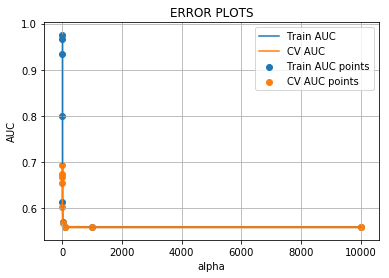

In [45]:
gbow = SGDClassifier(loss='hinge',penalty='l2')
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]}
gbowgs = GridSearchCV(gbow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
gbowgs.fit(X_tr1,y_tr)

train_auc= gbowgs.cv_results_['mean_train_score']
train_auc_std= gbowgs.cv_results_['std_train_score']
cv_auc = gbowgs.cv_results_['mean_test_score'] 
cv_auc_std= gbowgs.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

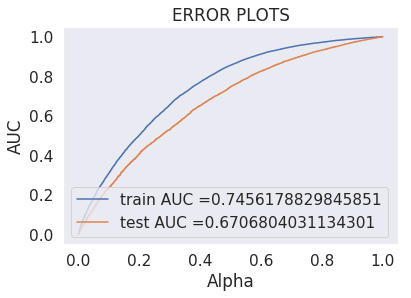

In [137]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

gbow = SGDClassifier(loss='hinge',penalty='l2', alpha=0.1)
gbow.fit(X_tr1,y_tr)
model = CalibratedClassifierCV(gbow)
model.fit(X_tr1,y_tr) 

y_train_pred = batch_predict(model, X_tr1)    
y_test_pred = batch_predict(model, X_te1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999796471448 for threshold 0.795


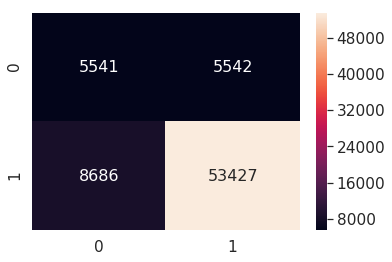

In [134]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix


print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_tr, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 0.854


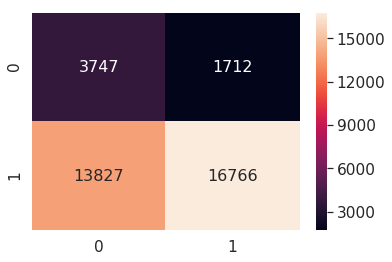

In [128]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_te, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## TF-IDF

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4)) 
tfvectorizer.fit(X_tr['essay'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_summary_tfidf = tfvectorizer.transform(X_tr['essay'].values)
X_test_summary_tfidf = tfvectorizer.transform(X_te['essay'].values)

print("After vectorizations")
print(X_train_summary_tfidf.shape, y_tr.shape)
print(X_test_summary_tfidf.shape, y_te.shape)

After vectorizations
(73196, 258824) (73196,)
(36052, 258824) (36052,)


In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfvectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,4))  #if needed max_features=5000 in brackets
tfvectorizer.fit(X_tr['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_title_tfidf = tfvectorizer.transform(X_tr['project_title'].values)
X_test_project_title_tfidf = tfvectorizer.transform(X_te['project_title'].values)

print("After vectorizations")
print(X_train_project_title_tfidf.shape, y_tr.shape)
print(X_test_project_title_tfidf.shape, y_te.shape)

After vectorizations
(73196, 12791) (73196,)
(36052, 12791) (36052,)


In [71]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
tX_tr = hstack((X_train_summary_tfidf,X_train_project_title_tfidf, X_train_state_ohe, X_train_teacher_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_grade_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
tX_te = hstack((X_test_summary_tfidf,X_test_project_title_tfidf, X_test_state_ohe, X_test_teacher_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_grade_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(tX_tr.shape, y_tr.shape)
print(tX_te.shape, y_te.shape)

Final Data matrix
(73196, 271716) (73196,)
(36052, 271716) (36052,)


In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

bowtf = SGDClassifier(loss='hinge')
parameters = {'penalty':['l1','l2'], 'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]} 
bowgstf = GridSearchCV(bow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
bowgstf.fit(tX_tr,y_tr)
print("Best HyperParameters are ",bowgstf.best_params_)

Best HyperParameters are  {'alpha': 0.001, 'penalty': 'l2'}


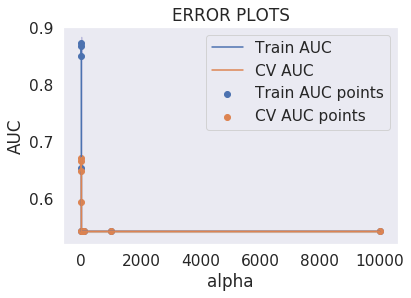

In [146]:
gbow = SGDClassifier(loss='hinge',penalty='l2')
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]}
gbowgs = GridSearchCV(gbow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
gbowgs.fit(tX_tr,y_tr)

train_auc= gbowgs.cv_results_['mean_train_score']
train_auc_std= gbowgs.cv_results_['std_train_score']
cv_auc = gbowgs.cv_results_['mean_test_score'] 
cv_auc_std= gbowgs.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

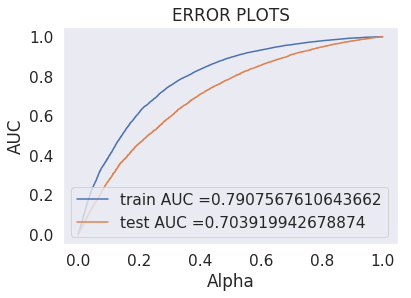

In [147]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

gbow = SGDClassifier(loss='hinge',penalty='l2', alpha=0.001)
gbow.fit(tX_tr,y_tr)
model = CalibratedClassifierCV(gbow)
model.fit(tX_tr,y_tr) 

y_train_pred = batch_predict(model, tX_tr)    
y_test_pred = batch_predict(model, tX_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 1.0


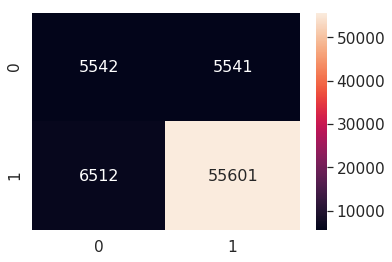

In [148]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix


print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_tr, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.24999999161092998 for threshold 1.0


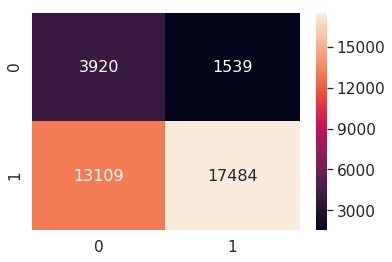

In [149]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_te, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## AVG W2V

In [35]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [154]:
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))

100%|██████████| 109248/109248 [00:29<00:00, 3681.48it/s]

109248


In [155]:
aX_train, aX_test, y_tr, y_te = train_test_split(avg_w2v_vectors, y, test_size=0.33, stratify=y)

In [156]:
tavg_w2v_vectors = []; 
for sentence in tqdm(X['project_title']): 
    vector = np.zeros(300) 
    cnt_words =0; 
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    tavg_w2v_vectors.append(vector)

print(len(tavg_w2v_vectors))

100%|██████████| 109248/109248 [00:01<00:00, 59786.05it/s]

109248


In [173]:
aaX_train, aaX_test, y_tr, y_te = train_test_split(tavg_w2v_vectors, y, test_size=0.33, stratify=y)

In [159]:
aX_tr = hstack((aX_train,aaX_train, X_train_state_ohe, X_train_teacher_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_grade_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
aX_te = hstack((aX_test,aaX_test, X_test_state_ohe, X_test_teacher_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_grade_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(aX_tr.shape, y_tr.shape)
print(aX_te.shape, y_te.shape)

Final Data matrix
(73196, 701) (73196,)
(36052, 701) (36052,)


In [160]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

bow = SGDClassifier(loss='hinge')
parameters = {'penalty':['l1','l2'], 'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]} 
bowgs = GridSearchCV(bow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
bowgs.fit(aX_tr,y_tr)
print("Best HyperParameters are ",bowgs.best_params_)

Best HyperParameters are  {'alpha': 0.001, 'penalty': 'l2'}


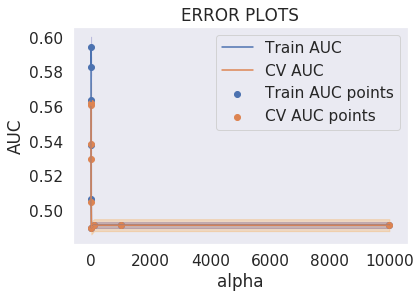

In [161]:
gbow = SGDClassifier(loss='hinge',penalty='l2')
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]}
gbowgs = GridSearchCV(gbow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
gbowgs.fit(aX_tr,y_tr)

train_auc= gbowgs.cv_results_['mean_train_score']
train_auc_std= gbowgs.cv_results_['std_train_score']
cv_auc = gbowgs.cv_results_['mean_test_score'] 
cv_auc_std= gbowgs.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

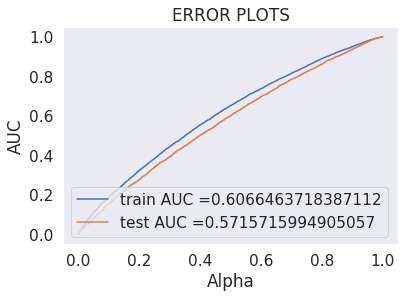

In [170]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

gbow = SGDClassifier(loss='hinge',penalty='l2', alpha=0.001)
gbow.fit(aX_tr,y_tr)
model = CalibratedClassifierCV(gbow)
model.fit(aX_tr,y_tr) 

y_train_pred = batch_predict(model, aX_tr)    
y_test_pred = batch_predict(model, aX_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.843


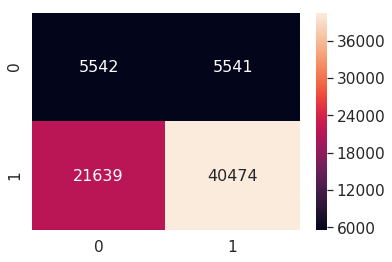

In [171]:
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_tr, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

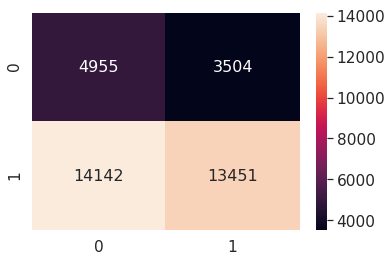

In [82]:
#print("Test confusion matrix")
#df_cm = pd.DataFrame(confusion_matrix(y_te, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
#sns.set(font_scale=1.4)#for label size
sns.heatmap(a, annot=True,annot_kws={"size": 16}, fmt='g')

## TF-IDF W2V

In [36]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_tr['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())


# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))

100%|██████████| 109248/109248 [03:48<00:00, 477.92it/s]

109248


In [37]:
twX_train, twX_test, y_tr, y_te = train_test_split(tfidf_w2v_vectors, y, test_size=0.33, stratify=y)

In [38]:
ttfidf_model = TfidfVectorizer()
ttfidf_model.fit(X_tr['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(ttfidf_model.get_feature_names(), list(ttfidf_model.idf_)))
ttfidf_words = set(ttfidf_model.get_feature_names())

ttfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    ttf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in ttfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            ttf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * ttf_idf) # calculating tfidf weighted w2v
            ttf_idf_weight += ttf_idf
    if ttf_idf_weight != 0:
        vector /= ttf_idf_weight
    ttfidf_w2v_vectors.append(vector)

print(len(ttfidf_w2v_vectors))

100%|██████████| 109248/109248 [00:04<00:00, 26642.11it/s]

109248


In [39]:
atwX_train, atwX_test, y_tr, y_te = train_test_split(ttfidf_w2v_vectors, y, test_size=0.33, stratify=y)

In [40]:
from scipy.sparse import hstack
twX_tr = hstack((twX_train,atwX_train, X_train_state_ohe, X_train_teacher_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe, X_train_grade_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
twX_te = hstack((twX_test,atwX_test, X_test_state_ohe, X_test_teacher_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe, X_test_grade_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(twX_tr.shape, y_tr.shape)
print(twX_te.shape, y_te.shape)

Final Data matrix
(73196, 701) (73196,)
(36052, 701) (36052,)


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

bow = SGDClassifier(loss='hinge')
parameters = {'penalty':['l1','l2'], 'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]} 
bowgs = GridSearchCV(bow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
bowgs.fit(twX_tr,y_tr)
print("Best HyperParameters are ",bowgs.best_params_)

Best HyperParameters are  {'alpha': 0.0001, 'penalty': 'l1'}


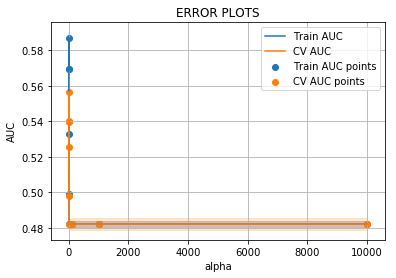

In [42]:
gbow = SGDClassifier(loss='hinge',penalty='l2')
parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1,10**0,10**1, 10**2,10**3, 10**4]}
gbowgs = GridSearchCV(gbow,parameters,cv=3,scoring='roc_auc', n_jobs=-1)
gbowgs.fit(twX_tr,y_tr)

train_auc= gbowgs.cv_results_['mean_train_score']
train_auc_std= gbowgs.cv_results_['std_train_score']
cv_auc = gbowgs.cv_results_['mean_test_score'] 
cv_auc_std= gbowgs.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

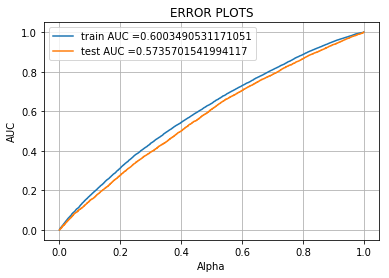

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

gbow = SGDClassifier(loss='hinge',penalty='l1', alpha=0.0001)
gbow.fit(twX_tr,y_tr)
model = CalibratedClassifierCV(gbow)
model.fit(twX_tr,y_tr) 

y_train_pred = batch_predict(model, twX_tr)    
y_test_pred = batch_predict(model, twX_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.2499999979647145 for threshold 0.844


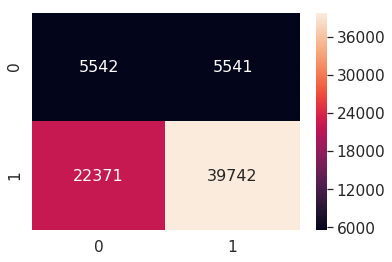

In [44]:
print("Train confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_tr, predict(y_train_pred, tr_thresholds, train_fpr, train_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

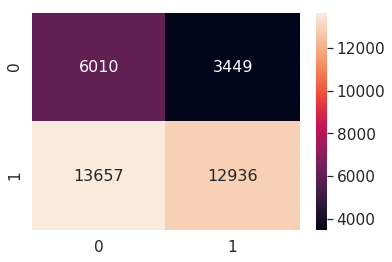

In [78]:
print("Test confusion matrix")
df_cm = pd.DataFrame(confusion_matrix(y_te, predict(y_test_pred, tr_thresholds, test_fpr, test_fpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Summary

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter","TrainAUC","TestAUC"]

x.add_row(["BOW", "l2", 0.1, 0.74, 0.67])
x.add_row(["TFIDF", "l2", 0.001, 0.79, 0.70])
x.add_row(["AVG W2V", "l2", 0.001, 0.60, 0.57])
x.add_row(["TFIDF W2V", "l1", 0.0001, 0.60, 0.57])


print(x)

+------------+-------+----------------+----------+---------+
| Vectorizer | Model | Hyperparameter | TrainAUC | TestAUC |
+------------+-------+----------------+----------+---------+
|    BOW     |   l2  |      0.1       |   0.74   |   0.67  |
|   TFIDF    |   l2  |     0.001      |   0.79   |   0.7   |
|  AVG W2V   |   l2  |     0.001      |   0.6    |   0.57  |
| TFIDF W2V  |   l1  |     0.0001     |   0.6    |   0.57  |
+------------+-------+----------------+----------+---------+
